# Building Bayesian models of trajectories in dynamical physical systems using PyMC3
## This article explores the ability of Bayesian models of trajectories to learn the properties of linear time dependent physical processes from observed data, using Normal, Student-T and Gaussian Random Walk priors. These models are tested against simulated noisy measurements and observations, with simulated outliers and missing observations, and are evaluated for their predictive power to generate trajectories beyond the sample domain.

![Bayesian Inference](http://www.appliedmachinelearning.ai/assets/images/pymc3_trajectory_model/grw_result_3d.png "Building Bayesian models of trajectories in dynamical physical systems using PyMC3")
### Overview
Many physical systems can be described in terms of trajectories through a vector space. The notion of a trajectory is important as it implies causality and sequence and captures the expectation that an observation at point $t$ is in some way related to a prior observation at $t−1$. This allows us to ascribe smoothness and single-valued continuity to our observational data, which is the basis of linear regression and non-parametric methods, and gives us the ability to infer predictive linear$^*$ models from sample data and hence extrapolate into unobserved regions. ([6] Léon Bottou "Nature doesn’t shuffle… so maybe we shouldn’t": [Learning Representations Using Causal Invariance](https://www.april.sh/blog/2019/05/06/leon-bottou))

Trajectories are often described in the time dimension but in general any coordinate where the model state at some index $i$ can be computed from a previous state $i−1$ implies a trajectory. ([7] Parameter Trajectory Analysis to Identify Treatment Effects of Pharmacological Interventions).

For earlier work see [The Power of Bayesian Inference estimated using PyMC3](http://www.appliedmachinelearning.ai/assets/pymc3_glm.html), and valuable material from Thomas Wiecki https://discourse.pymc.io/u/twiecki/summary, Junpeng Lao https://discourse.pymc.io/u/junpenglao/summary, https://discourse.pymc.io/t/oos-predictions-with-missing-input-values/423 and Juan Camilo Orduz https://juanitorduz.github.io/about/. Also ref [8] Gelman, [A default prior distribution for logistic and other regression models](http://www.stat.columbia.edu/~gelman/research/unpublished/priors3.pdf).

### Roadmap
1. General discussion of trajectories, representation and visualization
2. Example trajectory scenarios: Linear, Polynomial, Nonlinear
3. Scenario setup: Python code defaults
4. Scenario definitions
5. Visualizing example trajectory scenarios: Matplotlib helpers and 2D visualizations
6. Experiments: building model priors and simulated data
7. Visualization of the test scenario: helpers and 3D visualizations
8. Bayesian inference learning models: compute PyMC3 regression, Normal, Student-T, Gaussian Random Walk, sample data runs, with and without outliers
9. Results: posterior predictions and generated trajectory comparisons
10. Cumulative test results: RMSE summaries of trajectory tests

## 1 Trajectories
We can construct trajectories of $x$ through $t$ with observed $z=f(x,t)$, trajectories represented as ordered sequential equidistance steps in $t$, indexed on an integer $i$, and fixed step size in $t$, $delta_t$, with path defined in terms of the coordinate $x$ at each step $t_i$. Hence our trajectory can be written as a $z=f(x(t),t)$. $z$ has a direct dependency on $t$, combined with an indirect dependency due to the dependency of $x$ on $t$. We assume that $z$ and $t$ are scalars. In general $x$ could be multivariate but here we consider the one-dimensional case only.

Below we build multiple trajectories through the vector space from which we attempt to learn the parameters of the mathematical linear model $f(x,t)$. If the model parameters are represented as priors $θ$, the task is a Bayesian regression of $z=f(θ,x,t)$ conditioned on the observations $z_{obs}$ over $x$ and $t$.
### 1.1 Specification of trajectories
If the equation $z = f(x,t)$ describes a smooth surface in the $[x,t]$ vector space, a trajectory is a one-dimensional line across this surface specified by the path $x(t)$. This equation describes the time evolution of the dynamical physical system we are considering and captures some causal process derived from the physics of the system. In the Feynman formulation of quantum mechanics a system traverses many paths simultaneously, each with a certain known probability ([4] Quantum Mechanics and Path Integrals).

We can consider three degrees of complexity in the trajectory paths $x$ over $t$:

1. **Linear model** In the simple case, for each trajectory, $x$ has an initial value which does not vary with $t$. Then each trajectory, index $n$, can be written as $z_n = f(x_n, t)$, where $x_n$ is a constant for that trajectory. For example in streamlined linear flow, the depth of a flow, $x_n$, as it passes through a barrier may remain unchanged from the initial depth $x_n(t_0)$, with the downstream velocity of the flow $v_n$ a function of the initial depth and time, $v_n = f(x_n(t_0), t)$.
2. **Polynomial model** In the second case we consider that for each trajectory, the observable $z_n(t)$ is a function of $x$ and $t$ as before but the path $x_n(t)$ varies linearly over time. This leads to a polynomial type of dependency of $z$ on $t$. In the example above, if the flow passes over deformities in a riverbed, the depth $x$ may deviate from its initial value, with a corresponding change in the velocity $v_n(t) = f(x_n(t), t)$. The path of the trajectories can give a mapping of the riverbed topology. We must assume that the deviation of the flow, $x$ is not dependent on the velocity $v$, otherwise we will need to consider a non-linear model, below.
3. **Nonlinear model** In the case where the observed values $z$ varies with $x$ over $t$ and simultaneously the path coordinate $x$ of the trajectory changes with a dependency on $z$, we have to consider a non-linear model:

> $z(t) = f(x(t), t)$

> $x(t) = f(z(t), t)$

> #### Simple Spring (Ref [The Damped Harmonic Oscillator](https://quantumcoffee.wordpress.com/2014/07/16/the-damped-harmonic-oscillator/))
For example for a simple spring with spring constant $k$, and a mass $m$, potential energy is a function of spring extension, and kinetic energy a function of the velocity of the mass. If we think of the mass's momentum $M$ as fixed, the mass will continue in uniform motion with momentum $M=m \dot{x}$. But the potential energy term resists this motion by transferring kinetic energy into potential energy as $x$ increases. In the Langrangian formulation this imposes a constraint on $x$ in terms of a rate of change of momentum $dM(t)/dt = -kx$. This is shown from the Lagrangian $L = \frac{1}{2}m\dot{x}^2 - \frac{1}{2}kx^2$, which combined with Euler-Lagrange minimisation [5], gives us:

> [1.2.1.1] Generalised potential ${dM(t)}/{dt} ={\partial L}/{\partial x} = - kx(t)$ 

> [1.2.1.2] Generalised momentum $M(t) = {\partial L}/{\partial \dot{x}} = m \dot{x}(t)$

## 2 Example trajectory scenarios
We construct sample trajectories based on a simple linear model $z = ax + bt$, observed at coordinates $(x, t)$. We allow a and b to vary linearly as a function of $x$. Hence $a = a_0 + px$ and $b = b_0 + qx$. If we expand this out we get a useful simple formulation for $z$ with which we can test our models:
> $z = (a_0+px)x + (b_0+qx)t$

> $z = a_0x+b_0t+px^2 + qxt$

In order to fully represent our trajectories we need to learn the parameters $a_0$, $b_0$, $p$, $q$.

We will test our model over a set of trajectories $n$, and we also need to model the path $x_n(t)$.

As described above we have three scenarios:

### 2.1 Linear model
> $x(t) = x_n$, where $x_n$ is a constant for each trajectory $n$

### 2.2 Polynomial model
> $x(t) = x_n(t_0) + v*t$, where $x_n(t_0)$ is an initial coordinate value and $v$ is a linear gradient of $x$ over $t$. The consequence of this variation in path $x$ over $t$ is that $z_n(t)$ is quadratic in $t$.
 
### 2.3 Nonlinear model - Mass $m$ on spring with spring constant $k$
> $dz(t) = -kx(t)dt$ from [1.2.1.1]

> $dx(t) = \frac{z(t)}{m}dt$ from [1.2.1.2]
 
> We can construct each trajectory $n$ numerically with the following steps, at each iteration $i$ in $t$:

> for each $i$ > 0 in $trajectory_n$

> > $dz = -k * x_n(i-1)*dt$

> > $z_n(i) = z_n(i-1) + dz$

> > $x_n(i) = x_n(i-1) + z_n(i)/m * dt$

## 3 Scenario setup
Our input space is created on a 2-dimensional mesh of x and t. Each step in x represents a new trajectory and each step in t an iteration in the trajectory time evolution. The observables, z, are calculated from one of the three models as specified above.

Model parameters are specified in code as ***slope*** = {$a_0, b_0$} and ***slope_bias*** = {$p, q$}, with other defaults as initialised below:

In [1]:
%matplotlib inline
#%matplotlib widget

import numpy as np
import seaborn
import matplotlib.pyplot as plt
from matplotlib import cm
import pymc3 as pm
import pandas as pd
from sklearn.metrics import mean_squared_error
import theano.tensor as tt

RANDOM_SEED = 123

# True linear model
slope = np.array([0.7, 1.5]) # (a_0,b_0) slope of observations z = a * x + b * t
slope_bias = np.array([-0.3, -.6]) # (p, q) amount by which each slope parameter varies, hence a = a_0 + p * x, b = b_0 + q * x
v_dxdt = 0.42 # amount by which linear x path varies with t, hence x = x_0 + v_dxdt * t
ratio_missing_observations = .1 # ratio of missing observations
n_hidden_z = 0 # global for number of missing observations
sigma_x_noise = 0.1 # amount of noise in measurement data
sigma_z_noise = 0.2 # amount of noise in observational data

training_trajectories = 10 # how many trajectories to use for training of predictive model

# Outliers
outlier_mean, outlier_sd = 0.8, 0.4 # size and sd of outlier distribution
outlier_index_range = [2, 3, 4, 14, 15] # range of observations to make into outliers

# Grid sample space
x_abs_min, x_abs_max = 6, 6
t_abs_min, t_abs_max = 0, 4
z_abs_min, z_abs_max = 24, 10
z_abs_min_t, z_abs_max_t = 24, 10 # used for contours but not for axes
obs_delta = (1, 0.2) # interval steps in sample space x, t

# Plot theme
seaborn.set_style("whitegrid")
pal_1 = seaborn.light_palette('green')
pal_2 = seaborn.light_palette('blue')
pal_3 = seaborn.light_palette('red')

# Plot scaling
fig_size_x, fig_size_y = 12, 6

# Sampling
samples_predictive = 2500
tune_predictive = 1500

# Reporting
result_cols = np.array(['Model', 'Slope $x$', 'Slope $t$', 'Slope bias $a(t)$', 'Slope bias $b(t)$', 'v_dxdt', f'RMSE'])
quartiles = [5.5, 25, 50, 75, 94.5] # Credibility Intervals
no_quartiles = len(quartiles)

# setup default trajectories of x by t on grid
xt_true_0 = np.mgrid[-x_abs_min:x_abs_max+.1:obs_delta[0], -t_abs_min:t_abs_max+.1:obs_delta[1]]

## 4 Scenario definitions

In [2]:
# 2.1 Simple linear model with slope = [a, b] constant
def get_default_trajectory(xt_mesh, slope):
    return np.dot(xt_mesh.T, slope).T

# 2.1 Simple linear model 
def get_z_obs_trajectory(xt_mesh, slope, slope_bias):
    return get_default_trajectory(xt_mesh, slope) + (xt_mesh[0] * xt_mesh[0] * slope_bias[0]) + (xt_mesh[0] * xt_mesh[1] * slope_bias[1])

# 2.2 Polynomial model
def get_x_path_trajectory(xt_mesh, v_dxdt):
    xt = xt_mesh.copy()
    xt[0] += xt[1] * v_dxdt # x = x + vt
    return xt

# 2.3 Nonlinear model
def get_sho_trajectory(xt_mesh, z_t, delta_t, k, m):
    xt = xt_mesh.copy()
    z_obs = z_t.copy()
    for n in range(z_obs.shape[0]):
        z = z_obs[n, 0] # initial z value
        x = xt[0, n, 0] # initial x value
        for it in range(1, xt.shape[2]):
            dz = -(k * x) * delta_t
            z += dz
            x += (z/m) * delta_t
            z_obs[n, it] = z
            xt[0, n, it] = x

    return xt, z_obs

## 5 Visualizing example trajectory scenarios
For plotting we have used [Matplotlib](https://matplotlib.org/), with various helper functions defined below. Note that for 3D **interactive** visualization when running inside Jupyter notebook the setup ***%matplotlib inline*** should be replace by ***%matplotlib widget***.
### 2D Plot helper functions

In [3]:
def get_line_text(slope, slope_bias, v=None):
    line = f'[$a_0$={slope[0]}, $b_0$={slope[1]}]'
    fall_line = f'[p={slope_bias[0]}, q={slope_bias[1]}]'
    if v is not None:
        fall_line += f', [v={v}]'
    return line, fall_line

def plot_2d_contor(fig, mesh, z, cmap, l_min, l_max):
    contour_levels = np.linspace(l_min, l_max, (1 - l_min + l_max))
    x, t = mesh[0], mesh[1]
    cp = plt.contourf(t, x, z, cmap=cmap, alpha=.75, levels=contour_levels)
    fig.colorbar(cp, shrink=1.0)

def plot_mesh(mesh):
    x, t = mesh[0], mesh[1]
    plt.plot(t, x, color='white', lw=0.5)
    plt.plot(t.T, x.T)
    return x, t

def plot_2d_grid(ax, mesh, title):
    x, t = plot_mesh(mesh)
    ax.set_title(title)
    ax.set_xlabel(f'$t, [delta_t = {obs_delta[1]}]$')
    ax.set_ylabel(f'$x, [delta_x = {obs_delta[0]}]$')
    ax.set_xlim(-t_abs_min, t_abs_max)
    return x, t

def scatter_plot(ax, x, t, label, color, m, z=None):
    if(z is None):
        ax.scatter(t, x, s=12, label=label, color=color, marker=m, zorder=4)
    else:
        ax.scatter(t, x, z, s=12, label=label, color=color, marker=m, depthshade=False, zorder=4)

def plot_2d_trajectory(ax, x, t, mask, outlier_indexes, show_label, z=None):
    l_obs, l_out, l_hidden = '', '', ''

    if(show_label):
        l_hidden = f'Missing observations [{n_hidden_z}]'
    
    if outlier_indexes:
        n_outliers = len(outlier_indexes)
        if(show_label):
            l_obs = f'Observations'
            l_out = f'Outliers [{n_outliers}]'
        x_out, x_ = crop_outliers(x, outlier_indexes)
        t_out, t_ = crop_outliers(t, outlier_indexes)
        if(z is None):
            z_out, z_= None, None
        else:
            z_out, z_= crop_outliers(z, outlier_indexes)
        scatter_plot(ax, x_, t_, l_obs, pal_2[4], '.', z_)
        scatter_plot(ax, x_out, t_out, l_out, 'orange', 'o', z_out)
    else:
        if(show_label):
            l_obs = f'Observations'
        scatter_plot(ax, x, t, l_obs, pal_2[4], '.', z)
    
    if n_hidden_z > 0 and mask is not None:
        plot_hidden_observations(ax, x, t, z, mask, l_hidden)

def plot_trajectories(ax, z, title, mask, outlier_indexes):
    t = np.arange(z.shape[1])
    mask_t = None

    for ix in range(z.shape[0]):
        if(mask is not None):
            mask_t =  mask[ix]
        plot_2d_trajectory(ax, z[ix], t, mask_t, outlier_indexes, ix==0)
    plt.plot(z.T, '-')
    ax.set_title(title)
    ax.set_xticks(t)
    ax.set_xlabel('Trajectory iteration')
    ax.set_ylabel('$z$')
    ax.set_xlim(0, len(t) - 1)
    ax.set_ylim(-z_abs_min_t, z_abs_max_t)
    plt.legend(loc=2)

def plot_2d_and_contor(fig, row, z, xt_mesh, title, z_obs=None, outlier_index_range=None):
    if z_obs is None:
        l_min, l_max = -z_abs_min_t, z_abs_max_t
    else:
        l_min, l_max = int(np.rint(z_obs.min())), int(np.rint(z_obs.max()))
    ax1 = fig.add_subplot(gs[row, :2])
    plot_trajectories(ax1, z, title, None, outlier_index_range)
    ax2 = fig.add_subplot(gs[row, 2])
    plot_2d_grid(ax2, xt_mesh, '$z_n(x,t)$')
    plot_2d_contor(fig, xt_mesh, z, cm.coolwarm, l_min, l_max)

### 5.1 Linear trajectory model
Here we visualize the simple linear model, with $x$ constant for each trajectory, for the case of $a$ and $b$ as fixed constants and for the case where $a$ and $b$ vary with $x$ by the parameters $p$ and $q$. Note that even though the surface is quadratic, each trajectory is linear.

Text(0.5, 0.98, 'Simple linear model [$a_0$=0.7, $b_0$=1.5] [p=-0.3, q=-0.6].')

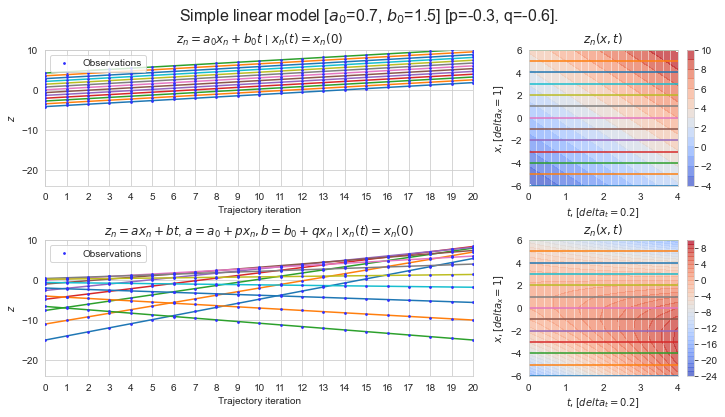

In [4]:
# Scenario 1 - Linear model with x(t) constant
z_true_0 = get_default_trajectory(xt_true_0, slope)
z_true_1 = get_z_obs_trajectory(xt_true_0, slope, slope_bias)

model_header = '$z_n=ax_n+bt$', '$a=a_0 + px_n, b=b_0 + qx_n$'  
true_line, true_fall_line = get_line_text(slope, slope_bias)  
fig = plt.figure(figsize=(fig_size_x, fig_size_y))
gs = fig.add_gridspec(ncols=3, nrows=2, wspace=0.3, hspace=0.4)
plot_2d_and_contor(fig, 0, z_true_0, xt_true_0, f'$z_n = a_0x_n + b_0t$ | $x_n(t) = x_n(0)$', z_true_0)
plot_2d_and_contor(fig, 1, z_true_1, xt_true_0, f'{model_header[0]}, {model_header[1]} | $x_n(t) = x_n(0)$')
fig.suptitle(f'Simple linear model {true_line} {true_fall_line}.', fontsize=16)

### 5.2 Polynomial trajectory model
In this case we allow the path of $x(t)$ to vary linearly over $t$. $z$ is now polynomial in $x$ and $t$.

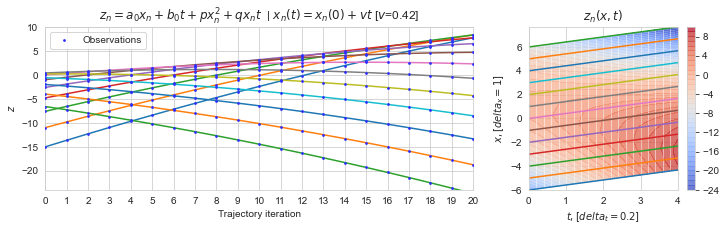

In [5]:
# Scenario 2 - Polynomial model with x(t) path
xt_true_2 = get_x_path_trajectory(xt_true_0, v_dxdt) # get path
z_true_2 = get_z_obs_trajectory(xt_true_2, slope, slope_bias) # get obs from path

fig = plt.figure(figsize=(fig_size_x, fig_size_y/2))
gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)
plot_2d_and_contor(fig, 0, z_true_2, xt_true_2, f'$z_n = a_0x_n+b_0t+px_n^2 + qx_nt$  | $x_n(t) = x_n(0) + vt$ [$v$={v_dxdt}]')

### 5.3 Nonlinear trajectory model
In this case we numerically compute the path $x(t)$ as described in 2.3 above, giving us the anticipated simple harmonic behaviour.

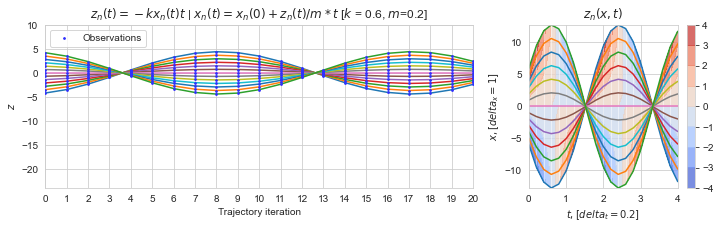

In [6]:
# Scenario 3 - Nonlinear model with x(t) from simple spring
k = - slope_bias[1] # spring constant
m = .2 # mass
xt_true_3, z_true_3 = get_sho_trajectory(xt_true_0, z_true_0, obs_delta[1], k, m)

fig = plt.figure(figsize=(fig_size_x, fig_size_y/2))
gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)
plot_2d_and_contor(fig, 0, z_true_3, xt_true_3, f'$z_n(t) = - kx_n(t)t$ | $x_n(t) = x_n(0) + z_n(t)/m * t$ [$k$ = {k}, $m$={m}]', z_true_3)

## 6 Experiments
Science proceeds from discovery and observation through to hypothesis, testing and prediction. Bayesian methods can tell us about the behaviour of underlying physical properties and the relationships between them in terms of priors and observed data, from which we can predict the likelihood of certain experimental outcomes. These predictions may lie within the space of the observed data, i.e. interpolation, or beyond, i.e. extrapolation, or out of the sample domain, i.e. prediction. In general prediction is much harder than interpolation or extrapolation as we must make assumptions about regions of space which we have not observed. A useful theory will fit observations in the sampled space but will also allow us to make testable predictions beyond the scope of our current knowledge.

### 6.1 Model priors

This article explores in some detail the polynomial trajectory scenario described, 2.2, using Python with PyMC3 to construct and test three Bayesian models:

1. **Normal**: Polynomial model with normal prior on observations
2. **Student-T**: Polynomial model with Student-T prior on observations
3. **Gaussian Random Walk (GRW)**: Polynomial model combined with non-parametric Gaussian random walk prior

Our prior belief for path measurements $x$ is that they vary linearly with $t$ with gradient $v_{xt}$, and observed $z=z_0+ax+bt$ where a and b are both allowed to vary as a function of $x$, with constant gradients p and q, $a=(a_0+p∗x)$, $b=(b_0+q∗x)$.
> $x(t) = x_0 + v_{xt} * t$

> $z(t)= (a_0+p*x)*x+(b_0+q*x)*t$ = $a_0*x+b_0*t+p*x^2 + q*x * t$

### 6.2 Testing experimental outcome
Given sample data generated from 'true' parameters, our objective in these experiments is to find a model which best infers the 'true' underlying sample data parameters $v_{xt}, a_0, b_0, p, q$ over a range of tests.

### 6.3 Noise in measurements and observations
We assume observations of $z$ at fixed time points $t_i$ over the predicted path $x(t)$. We allow that there is observational error in each modelled $z$, recorded as $z_{obs}(t_i)$, with prior mean $z(t)$. At each step in $t$ we also measure the coordinate $x_{obs}(t_i)$ conditioning the prior mean $x(t)$.

### 6.4 Outliers
T. Wiecki in his article [1] shows that a Student-T distribution is better than the Normal distribution at handling outliers in linear regression, as the Student-T distribution has longer tails than the Normal error prior. This conveys the notion that an outlier is not to be considered wholly unexpected.

The value of the GRW model is its ability to model local outlier behaviour while giving the inductive power of linear models to make predictions outside the sample space.

### 6.5 Missing data
A non-parametric model should always be able to model the observed data to any required degree of accuracy and so we hide a number of observations in order to test the model's interpolation of missing values.

The true test of the model is its ability to predict data that lies outside the sample space. This can be simulated by hiding some of the observed trajectories and then allowing the model to impute the values in these trajectories. This is much more challenging than imputing missing values that lie within the range of an observed trajectory, which is an interpolation task, or that lie beyond the extremity of a trajectory, which is an extrapolation task. We require that the model detect and apply inferred model parameters to predict along any new trajectory. To create this test we hide a given number of trajectories, keeping ***training_trajectories*** from which to learn the model parameters.

These tests are forms of "Leave-Out-One(LOO)/Leave-Out-Batch" model evaluation techniques, ref [9] Aki Vehtari: ***Model assessment, selection and averaging***, Aalto University

### 6.6 Simulated data
We simulate real data by applying the following perturbations to the 'true' sample data:

1. Measurement noise - each measurement $x$ has a Gaussian random noise element added, centred on the 'true' value $x(t)$
2. Observational noise - each observation $z$ has a Gaussian random noise element added, centred on the 'true' value $z(t)$
3. Anomalies/outliers - a set of points on each trajectory are displaced by random mean, with variance, which puts those observations beyond their anticipated value
4. Missing data - a number of randomly chosen observations are flagged as 'missing', or unobserved, which gives the inference model the task of imputing these missing values
5. Missing trajectories - a chosen number of trajectories are flagged as 'missing' giving the model the task of predicting out of sample trajectories from the model parameters

For test purposes we keep the 'true' data, from scenario 2.2, ***xt_true_2*** and ***z_true_2***, and our training data is calculated with and without ***_noise*** and with and without ***_missing_trajectories***.

### 6.7 Creating and visualizing simulated data


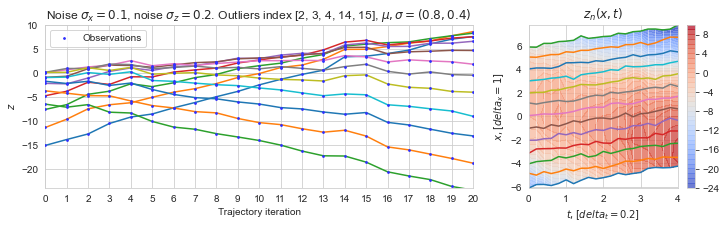

In [7]:
# Choose scenario
xt_target = xt_true_2
z_target = z_true_2

np.random.seed(RANDOM_SEED)

# Add noise to x measurement
xt_obs_noise = xt_target.copy()
xt_obs_noise[0] += pm.Normal.dist(mu=0, sigma=sigma_x_noise).random(size=xt_obs_noise[0].shape)

# Add observational noise
z_train_noise = z_target.copy()
z_train_noise += pm.Normal.dist(mu=0, sigma=sigma_z_noise).random(size=z_train_noise.shape)

# Add outliers
n_outliers = len(outlier_index_range)
z_train_noise[:, outlier_index_range] = z_train_noise[:, outlier_index_range] + np.random.normal(loc=outlier_mean, scale=outlier_sd, size=(z_train_noise.shape[0], n_outliers))

# Add missing observations
z_mask_missing = np.array(np.random.rand(z_train_noise.size) < ratio_missing_observations, dtype=int).reshape(z_train_noise.shape)
n_hidden_z = z_mask_missing.sum()
z_train_noise_with_outliers = np.ma.masked_array(z_train_noise, mask=z_mask_missing)

# Add missing trajectories
z_mask_trajectories = z_mask_missing.copy()
z_mask_trajectories[training_trajectories:] = 1
z_train_noise_missing_trajectories = np.ma.masked_array(z_train_noise_with_outliers, mask=z_mask_trajectories)

title =  f'Noise $\sigma_x = {sigma_x_noise}$, noise $\sigma_z = {sigma_z_noise}$. Outliers index {outlier_index_range}, $\mu, \sigma = {outlier_mean, outlier_sd}$'
fig = plt.figure(figsize=(fig_size_x, fig_size_y/2))
gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)
plot_2d_and_contor(fig, 0, z_train_noise, xt_obs_noise, title)

## 7 Visualization of the test scenario
In 2D projection it can be hard to visualize the sample space, measurements, trajectories and outliers. Here we adopt a wireframe and a contour plot to make the scenario a little clearer. Note that to animate Matplotlib charts within a Jupyter notebook, replace the rendering engine at the top of this notebook as follows: ***%matplotlib inline*** replace with ***%matplotlib widget***

As can be seen in the chart below, the effect of the linear model $z=ax+bt$, with variation in a and b parameters, $a=(a_0+p∗x)$, $b=(b_0+q∗x)$, and the path $x=x_0+v_{xt}t$ creates a parabolic noisy surface.

### 7.1 3D Plot helper functions

In [8]:
def crop_outliers(x, outlier_indexes):
    if len(x.shape) == 1:
        return x[outlier_indexes], np.delete(x, outlier_indexes, axis=0)
    else:
        return x[:, outlier_indexes], np.delete(x, outlier_indexes, axis=1)

def plot_hidden_observations(ax, x, t, z, mask, label):
        x_hidden = np.ma.masked_array(x, mask=mask==False)
        t_hidden = np.ma.masked_array(t, mask=mask==False)
        scatter_plot(ax, x_hidden, t_hidden, label, 'red', 's', z)

def plot_trajectories_surface(fig, ax, mesh, z, title, mask, outlier_indexes=None):
    x, t = plot_2d_grid(ax, mesh, title)
    plot_2d_contor(fig, mesh, z, cm.coolwarm, -z_abs_min_t, z_abs_max_t)
    plot_2d_trajectory(ax, x, t, mask, outlier_indexes, True)
    plt.legend(loc=2)
def plot_drop_lines(ax, x, y, z_obs, z_t):
     for ix in range(x.shape[0]):
        x_t, y_t, zo_t, zt_t = x[ix], y[ix], z_obs[ix], z_t[ix]
        for i in range(len(x_t)):
            ax.plot([x_t[i], x_t[i]], [y_t[i], y_t[i]], [zo_t[i], zt_t[i]], '-', linewidth=.5, color=pal_1[5], alpha=.8, zorder=3)
    
def plot_3d_grid(ax, title):
    ax.set_title(title)
    ax.set_xlabel(f'$t, [delta_t = {obs_delta[1]}]$')
    ax.set_ylabel(f'$x, [delta_x = {obs_delta[0]}]$')
    ax.set_xlim3d(-t_abs_min, t_abs_max)
    ax.set_ylim3d(-x_abs_min, x_abs_max)
    ax.set_zlim3d(-z_abs_min, z_abs_max)

def plot_3d_model(ax, mesh, z_test, x_obs, z_obs, mask, outlier_indexes, title, subtitle, contor):
    x, t = mesh[0], mesh[1]
    plot_3d_grid(ax, title)
    
    l_true = f'True: {true_line}, {true_fall_line}, [v={v_dxdt}]'
    if contor:
        ax.plot_surface(t, x, z_test, cmap=cm.coolwarm, alpha=.8)
        plot_hidden_observations(ax, x, t, z_test, mask, 'Missing observations')
        if z_obs is not None:
            ax.plot_wireframe(t, x_obs, z_obs, ccount=0, linewidth=0.75,  label='Observed data', color='magenta')
    else:
        ax.contourf(t, x, z_test, zdir='z', offset=-z_abs_min, cmap=cm.coolwarm)
        plot_2d_trajectory(ax, x, t, mask, outlier_indexes, True, z_test)     
        ax.plot_wireframe(t, x, z_test*0, linewidth=.75, color=pal_1[5])
        plot_drop_lines(ax, t, x, z_test, z_test*0)
    ax.plot_wireframe(t, x, z_test, ccount=0, linewidth=1, label=subtitle, color=pal_1[5])
    if x_obs is not None:
        ax.plot_wireframe(t, x_obs, np.full_like(z_test, -z_abs_min), color='magenta', alpha=0.5, ccount=0, linewidth=1)
    else:
        ax.plot_wireframe(t, x, np.full_like(z_test, -z_abs_min), color=pal_1[5], alpha=0.5, ccount=0, linewidth=1)
    ax.plot_wireframe(xt_target[1], xt_target[0], z_target, ccount=0, label=l_true, linewidth=1, alpha=0.5, color=pal_2[5])
    plt.legend(loc=2)

line, fall_line = get_line_text(slope, slope_bias)

Text(0.5, 0.98, 'Measured observables z with noise and outliers index [2, 3, 4, 14, 15]')

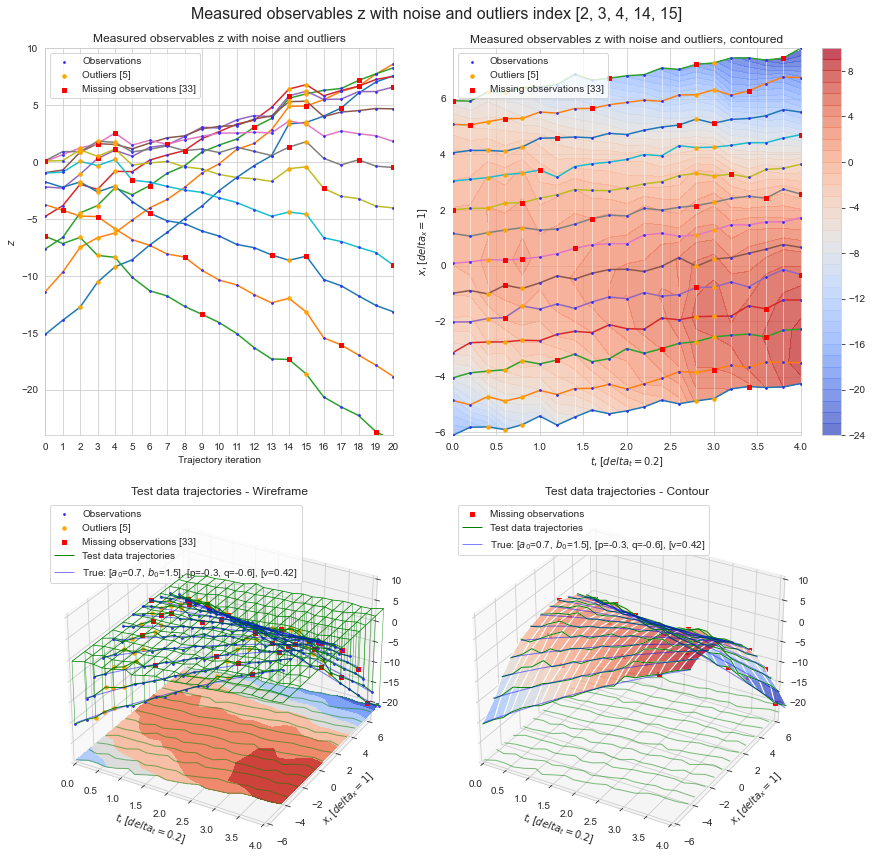

In [9]:
title =  f'x noise $\sigma_x = {sigma_x_noise}$, z noise $\sigma_z = {sigma_z_noise}$, outliers $\mu, \sigma = {outlier_mean, outlier_sd}$, missing ratio = ${ratio_missing_observations}$'
title = f'Measured observables z with noise and outliers'
fig = plt.figure(figsize=(fig_size_x, fig_size_y*2), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
ax1 = fig.add_subplot(gs[0, 0])

plot_trajectories(ax1, z_train_noise, title, z_mask_missing, outlier_index_range)
ax2 = fig.add_subplot(gs[0, 1])
plot_trajectories_surface(fig, ax2, xt_obs_noise, z_train_noise, title + ', contoured', z_mask_missing, outlier_index_range)

legend = 'Test data trajectories'
ax1 = fig.add_subplot(gs[1, 0], projection='3d')
plot_3d_model(ax1, xt_obs_noise, z_train_noise, None, None, z_mask_missing, outlier_index_range, legend + ' - Wireframe', legend, False)
ax2 = fig.add_subplot(gs[1, 1], projection='3d')
plot_3d_model(ax2, xt_obs_noise, z_train_noise, None, None, z_mask_missing, outlier_index_range, legend + ' - Contour', legend, True)
fig.suptitle(title + f' index {outlier_index_range}', fontsize=16)

### 7.2 Cross correlation data view
This plot is a conventional view of the relationship between the variables $x$, $t$ and $z$.

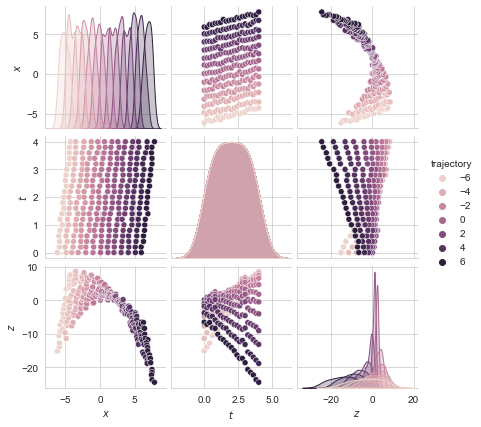

In [10]:
df = pd.DataFrame(data={'trajectory':xt_true_0[0].flatten(), '$x$':xt_obs_noise[0].flatten(), '$t$':xt_obs_noise[1].flatten(), '$z$':z_train_noise.flatten()})
seaborn.pairplot(df, height=2, hue='trajectory')

## 8 Bayesian inference learning models
### 8.1 Non-parametric models
Non-parametric methods such as Gaussian processes (GP) have been shown to be effective in modelling the fine structure of observed data by relying on assumptions about the degree of local smoothness of the observations. It is reasonable to assume that most physical processes are smoothly changing, with certain time constants, and this property allows us to make good interpolation of observed data. However if we have inferred only the properties of local smoothness (not considering methods using periodic or non-local kernels), we have not modelled the long range behaviour of the parameters, and our non-parametric model will revert to the unconditioned statistical mean of our priors outside the sample space.

### 8.2 Linear and polynomial models
These models make the assumption that there is a simple polynomial relationship between the predictor variables and the observed outcome. Once the model parameters have been inferred from the observational data, it is straightforward to make out of sample predictions. The strength of the model is its simplicity in modelling out of sample data.

### 8.3 Gaussian Random Walk (GRW)
Random walk is a stochastic, iterative process which generates a single connected line trajectory through an n-dimensional space. Each point on the trajectory is represented by its index, in relation to the previous point, and an n-dimensional vector representing the coordinate values at that point. Points on the trajectory are random n-vectors drawn from a known multivariate probability distribution

### 8.4 Model definitions
Below are the code definitions for the Normal, Student-T and GRW models which we going to test.

In each case, we setup a prior on the $x_{obs}$ path variables for intercept and common gradient $v_{dxdt}$. So each trajectory has a path $x_n(t) = x_n(0) + v_{dxdt} * t$. $x_0$ and $v_{dxdt}$ have simple Normal priors with $\mu=0$ and $\sigma = 1$.

We also set up the $z$ target function for $z_{obs}$ with ***slope*** $a_0$, $b_0$ and ***slope_bias*** p,q, with Normal priors $\mu=0$ and $\sigma = 20$. $z_n(t) = a_0*x_n+b_0*t+p*x_n^2 + q*x_n * t$, where $x_n$ is taken from the conditioned prior for x.

#### 8.4.1 Normal Model
For the Normal model we condition the prior for $z$ using a simple Normal prior, with $\mu$ taken from the $z$ target function and observational error prior $\sigma$ from Half Cauchy distribution having $\beta = 1$.

#### 8.4.2 Student-T Model
For the Student-T model we condition the prior for $z$ using a Student-T prior, with $\mu$ taken from the $z$ target function and observational error prior $\sigma$ from Half Cauchy distribution having $\beta = 1$ and degrees of freedom $\nu$ from Gamma distribution with $\alpha=2$ and $\beta = 0.1$. Please refer to our [previous article](http://www.appliedmachinelearning.ai/assets/pymc3_glm.html) for further discussion on this.

#### 8.4.3 Gaussian Random Walk Model
At each step the mean of the random vector draw is set to the value of the preceding point, such that successive points evolves along a connected path. A constant, known as 'drift', is added to every sample vector draw, having the effect of biasing the path in the observed data direction. We set the drift constants of the random walk path to be the gradient differences of the target function at each point along the path. This means that as we condition the random walk to the observed data, it will learn the values of the parameters that make up the drift, which are our target properties.

The GRW combines the properties of a non-parametric model, because it can easily track any path through the parameter space, with the ability to model a trend by learning the drift constants across the parameter space. The conditioning process samples many possible random walks along with a likelihood such that the mean random walk trajectory passes through the observations. 

We again use a Student-T prior to condition the observed data against the sample random walk draws with $\sigma = .2$ and degrees of freedom $\nu = 2$. If we did not have missing observations to deal with this would be sufficient to condition the random walk, but in the regions where we do not have observations the random walk can behave chaotically and the actual sample values diverge widely from the drift value, making the overall model ill-conditioned. To resolve this, we add a conditioning constraint that the sampled random walk should follow the target function $z$, with a Normal distribution at each point. Also, to make the random walk samples more stable we set a lower and upper bound on the prior distribution to keep the sample draws within 2.0 * the min and max values of the observed data.

The result of conditioning both on the computed function $z$ and the observational data $z_{obs}$ is that we are able to obtain a solution that satisfies both the noisy sample data, where it exists, and also the learned model in the regions of unobserved data. This is a tug of war between these two distributions and it has to be carefully setup with priors and prior meta parameters if it is to converge consistently in all the scenarios we have discussed. The model meta parameters were manually configured after tests to ensure robustness but this was a time-consuming and fragile process and a proper regularization regime is required for ongoing work.

In [11]:
def setup_model_x_obs(model, x, t): # Model prior measurement errors in x
    np.random.seed(RANDOM_SEED)
    with model:
        x_0 = pm.Normal('x_0', mu=0, sigma=1, shape=x.shape[0]) # each trajectory has its own intercept
        v_dxdt = pm.Normal('v_dxdt', mu=0, sigma=1) # all trajectories share a common gradient scalar
        x_true = x_0[:, None] + v_dxdt *  t # x = x_0 + v * t
        sigma_x_mu = pm.HalfCauchy('sigma_x_mu', beta=.1)
        return pm.Normal('x_obs', mu=x_true, sd=sigma_x_mu, observed=x, shape=x.shape)

def setup_model(model, mesh):
    with model:
        x, t = mesh[0], mesh[1]
        x_obs = setup_model_x_obs(model, x, t)
        slope = pm.Normal('slope', mu=0, sigma=20, shape=2)  
        slope_bias = pm.Normal('slope_bias', mu=0, sigma=20, shape=2)  
        return (x_obs * slope[0]) + (t * slope[1]) + (x_obs * x_obs * slope_bias[0]) + (x_obs * t * slope_bias[1])
        
def create_normal_linear_model(samples, tune, mesh, z):
    with pm.Model() as model:
        mu_obs_z = setup_model(model, mesh)
        sigma_obs = pm.HalfCauchy('sigma_obs', beta=1)
        obs = pm.Normal('o', mu=mu_obs_z, sigma=sigma_obs, observed=z)
        trace = pm.sample(samples, tune=tune, random_seed=123, cores=4, chains=4)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123, var_names=['o'])['o'], model

def create_studentt_linear_model(samples, tune, mesh, z):
    with pm.Model() as model:
        mu_obs_z = setup_model(model, mesh)
        sigma_obs = pm.HalfCauchy('sigma_obs', beta=1)
        nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)
        obs = pm.StudentT('o', mu=mu_obs_z, sigma=sigma_obs, nu=nu_0, observed=z)
        trace =  pm.sample(samples, tune=tune, random_seed=123, cores=4, chains=4)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123, var_names=['o'])['o'], model

def create_grw_model(samples, tune, mesh, z, observable_length=None):
    with pm.Model() as model:
        x, t = mesh[0], mesh[1]
        x_obs = setup_model_x_obs(model, x, t)

        # Define Linear model
        slope = pm.Normal('slope', mu=0, sigma=10, shape=2)  
        slope_bias = pm.Normal('slope_bias', mu=0, sigma=10, shape=2)  
        mu_obs_z = (x_obs * slope[0]) + (t * slope[1]) + (x_obs * x_obs * slope_bias[0]) + (x_obs * t * slope_bias[1])
        dz = mu_obs_z[:,1:] - mu_obs_z[:,:-1]

        mu_max = z.max() * 2.0
        mu_min = z.min() * 2.0
        # Gaussian random walk prior
        tau_grw = pm.Exponential("tau_grw", 0.1)
        mu_grw = []
        for ix in range(mesh.shape[1]):
            rw = pm.Bound(pm.GaussianRandomWalk, lower = mu_min, upper = mu_max)('mu_%i' % ix,
                mu=tt.shape_padleft(dz[ix], n_ones=1),
                tau=tau_grw,
                shape=mesh.shape[2], 
                init=pm.Normal.dist(mu=mu_obs_z[ix, 0], sigma=0.2))
            mu_grw.append(rw)
        mu = tt.stack(mu_grw)

        # Condition Linear model to GRW
        sigma_lm = 0.2
        grw = pm.Normal('g', mu=mu, sigma=sigma_lm, observed=mu_obs_z)
        # Condition observations to Linear model
        sigma_obs = .2
        nu_obs = 2
        obs = pm.StudentT('o', mu=mu, sigma=sigma_obs, nu=nu_obs, observed=z)
        # Sample
        trace = pm.sample(samples, tune=tune, random_seed=123, cores=4, chains=4)
        return trace, pm.sample_posterior_predictive(trace, random_seed=123, var_names=['o'])['o'], model

### 8.5 Model helpers

In [12]:
def get_model_params(xt_true, z_true, model_name, results_df, trace):
    slope_bias = np.array([trace['slope_bias'].mean(axis=0)[0], trace['slope_bias'].mean(axis=0)[1]])
    slope = np.array([trace['slope'].mean(axis=0)[0], trace['slope'].mean(axis=0)[1]])
    z_posterior_model = get_z_obs_trajectory(xt_true, slope, slope_bias)

    slope_bias = round(slope_bias[0], 4), round(slope_bias[1], 4)
    slope = round(slope[0], 4), round(slope[1], 4)
    v_dxdt = round(trace['v_dxdt'].mean(axis=0), 4)

    rmse = round(mean_squared_error(z_true, z_posterior_model, squared=False), 4)
    results_df = results_df.append(pd.DataFrame(np.array([[model_name, slope[0], slope[1], slope_bias[0], slope_bias[1], v_dxdt, rmse]]), columns=result_cols), ignore_index=True)

    return results_df, get_line_text(slope, slope_bias, v_dxdt), z_posterior_model
    
def plot_results_summary(results_df, title, trace1, trace2, z1, z2, x_obs, z_obs1, z_obs2):
    # Take median, not mean, as extreme outliers from random walk can skew mean. This is 50% percentile.
    z1_mean = np.median(z1, axis=0)
    z2_mean = np.median(z2, axis=0)

    fig = plt.figure(figsize=(fig_size_x, fig_size_y), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1)
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    results_df, txt, z_model1 = get_model_params(xt_target, z_target, f'{title} Model - inference', results_df, trace1)
    plot_3d_model(ax1, xt_target, z1_mean, x_obs, z_obs1, z_mask_missing, outlier_index_range, 'Inference and interpolation', f'Model: {txt[0]}, {txt[1]}', True)

    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    results_df, txt, z_model2 = get_model_params(xt_target, z_target, f'{title} Model - predictive from {training_trajectories} of {z_mask_trajectories.shape[0]}', results_df, trace2)
    plot_3d_model(ax2, xt_target, z2_mean, x_obs, z_obs2, z_mask_trajectories, outlier_index_range, f'Inference and predicting from {training_trajectories} of {z_mask_trajectories.shape[0]} trajectories', f'Model: {txt[0]}, {txt[1]}', False)
    fig.suptitle(f'{title} Model {model_header[0]}, {model_header[1]}', fontsize=16)
    return results_df, z_model1, z_model2

### 8.6 Setup results dataset
In this section we run each of the three models on the noisy data with all trajectories included for training, but with some missing observations, which we term the **Inference** model, and we also run each model on the same data but with some trajectories entirely hidden from the model, which we term the **Predictive** model, since it has to apply the learned model parameters to the trajectories not represented in the sample data. This latter is a challenging task, particularly in the non-parametric GRW case, as it is a true test that the model has learned the correct parameters of the target function and can make out of sample predictions. 

We have conducted various tests which show that it is challenging to get generalised models that perform well in multiple scenarios, with varying degrees of noise, outliers and missing data. The models are sensitive to the choice of priors and meta-parameters. We have tuned these models by hand, but clearly a robust regularization strategy would be preferred.

The run results sets are saved to a dictionary and tabulated at the end of this section.

Because we are using simulated data with added noise, we can calculate the RMSE of the simulated noise, with and without outliers, and include these in our summary figures for comparison purposes against our model outcomes.

In [13]:
rmse_noise = round(mean_squared_error(z_target, z_train_noise, squared=False), 4)
rmse_noise_observed = round(mean_squared_error(z_target[training_trajectories:], z_train_noise[training_trajectories:], squared=False), 4)
results_df = pd.DataFrame(np.array([
    ['True RMSE observed noise', slope[0], slope[1], slope_bias[0], slope_bias[1], v_dxdt, rmse_noise],
    ['True RMSE observed trajectories only', slope[0], slope[1], slope_bias[0], slope_bias[1], v_dxdt, rmse_noise_observed]
    ]), columns=result_cols)
results_df

Model Slope $x$ Slope $t$ Slope bias $a(t)$  \
0              True RMSE observed noise       0.7       1.5              -0.3   
1  True RMSE observed trajectories only       0.7       1.5              -0.3   

  Slope bias $b(t)$ v_dxdt    RMSE  
0              -0.6   0.42  0.3767  
1              -0.6   0.42  0.3559

### 8.7 Normal Model

In [14]:
# Linear model - Inference
trace_normal_lm, obs_normal_lm, model_normal_lm = create_normal_linear_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_with_outliers)
model_normal_lm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, sigma_obs, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
100%|██████████| 10000/10000 [00:16<00:00, 609.52it/s]


In [15]:
# Linear model - Predictive
trace_normal_lm_missing, obs_normal_lm_missing, model_normal_lm_missing = create_normal_linear_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_missing_trajectories)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, sigma_obs, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:42<00:00, 380.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 10000/10000 [00:15<00:00, 650.41it/s]


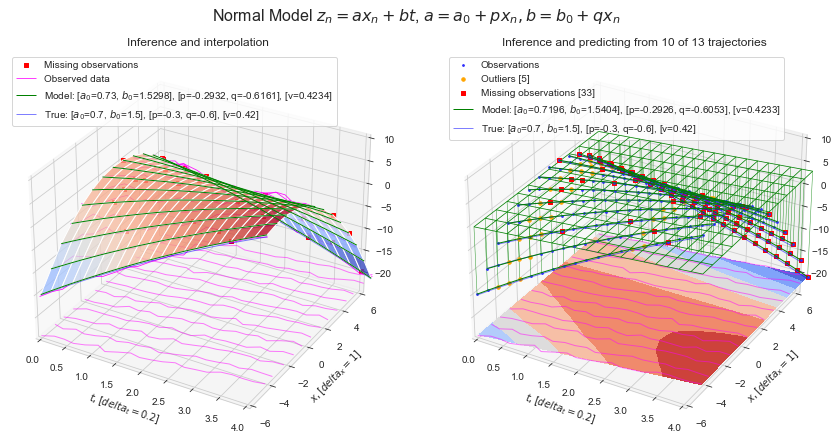

In [16]:
results_df, z_model_lm_1, z_model_lm_2 = plot_results_summary(results_df, f'Normal', trace_normal_lm, trace_normal_lm_missing, obs_normal_lm, obs_normal_lm_missing, xt_obs_noise[0], z_train_noise_with_outliers, z_train_noise_missing_trajectories)

#### 8.7.1 Posterior Traceplot of Normal model with no missing trajectories
From the ***traceplot*** below, we can see the posterior distributions for each of the priors, with 4 overlapping lines representing results for each chain.

It can be seen that the estimates for the observed x intercepts are very well defined and map to the true values, ranging from -6 to +6. Also the gradient v in the path x = x + vt is close to its true value of 0.42. This is encouraging as this prior is shared for all the three models, Normal, Student-T and GRW.

The parameters for slope and slope_bias, which hold $a_0$, $b_0$, $p$ and $q$, have smooth distributions, with clean estimates across all samples, with good overlap for the 4 different chains.

Finally, the imputed missing observations which are interpolated into the trajectories, represented by o_missing, are all well resolved.

This gives us confidence that the model is behaving well.

![Bayesian Inference](http://www.appliedmachinelearning.ai/assets/images/pymc3_trajectory_model/normal_traceplot.png "Building Bayesian models of trajectories in dynamical physical systems using PyMC3")

#pm.traceplot(trace_normal_lm)

### 8.8 Student-T Model

In [17]:
# Student-T model - Inference
trace_studentt_lm, obs_studentt_lm, model_studentt_lm = create_studentt_linear_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_with_outliers) 
model_studentt_lm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, nu_0, sigma_obs, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
100%|██████████| 10000/10000 [00:15<00:00, 662.94it/s]


In [18]:
# Student-T model - Predictive
trace_studentt_lm_missing, obs_studentt_lm_missing, model_studentt_lm_missing = create_studentt_linear_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_missing_trajectories)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, nu_0, sigma_obs, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:48<00:00, 327.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 10000/10000 [00:16<00:00, 617.16it/s]


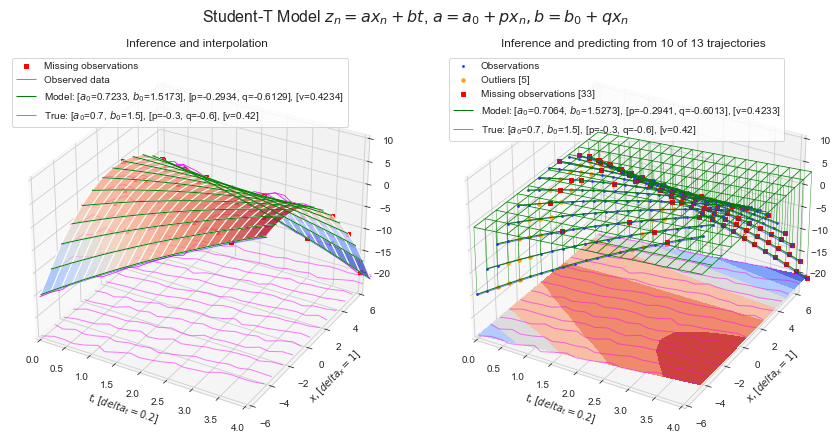

In [19]:
results_df, z_model_st_1, z_model_st_2 = plot_results_summary(results_df, f'Student-T', trace_studentt_lm, trace_studentt_lm_missing, obs_studentt_lm, obs_studentt_lm_missing, xt_obs_noise[0], z_train_noise_with_outliers, z_train_noise_missing_trajectories)

### 8.9 GRW Model

In [20]:
# GRW model - Inference
trace_grw, obs_grw, model_grw = create_grw_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_with_outliers)   
model_grw

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, mu_12, mu_11, mu_10, mu_9, mu_8, mu_7, mu_6, mu_5, mu_4, mu_3, mu_2, mu_1, mu_0, tau_grw, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [04:21<00:00, 61.11draws/s]
The acceptance probability does not match the target. It is 0.556580417962917, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 10000/10000 [00:12<00:00, 785.67it/s]


In [21]:
# GRW model - Predictive
trace_grw_missing, obs_grw_missing, model_grw_missing = create_grw_model(
    samples_predictive, tune_predictive, xt_obs_noise, z_train_noise_missing_trajectories)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_missing, mu_12, mu_11, mu_10, mu_9, mu_8, mu_7, mu_6, mu_5, mu_4, mu_3, mu_2, mu_1, mu_0, tau_grw, slope_bias, slope, sigma_x_mu, v_dxdt, x_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [03:39<00:00, 72.88draws/s]
The acceptance probability does not match the target. It is 0.8916915524854188, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 10000/10000 [00:14<00:00, 706.00it/s]


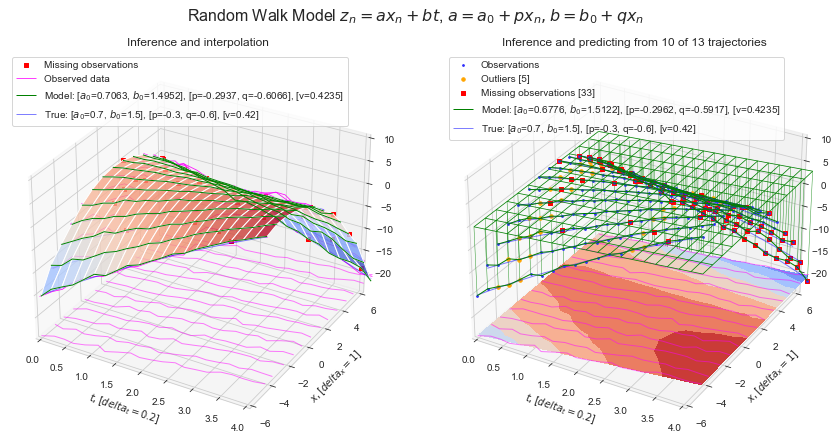

In [22]:
results_df, z_model_grw_1, z_model_grw_2 = plot_results_summary(results_df, f'Random Walk', trace_grw, trace_grw_missing, obs_grw, obs_grw_missing, xt_obs_noise[0], z_train_noise_with_outliers, z_train_noise_missing_trajectories)

## 9 Results
Other than by visual inspection, the best way to compare the above models is to find an objective measure of how closely the inferred parameters generate the true data values. If for each model run we take the parameters, and use them to compute the data across a grid of x and t coordinates, we can compare the computed values against our original clean 'true' $z$ data values and take the Root Mean Square (RMSE) difference across observed and unobserved data. RMSE is a good comparative measure of how closely different data sets match a reference data set. The units of measure of RMSE are the original coordinate units.

We have tabulated below the learned parameter values and the RMSE for each model, trained with all trajectories as inputs, ***inference***, and trained with some missing trajectories, ***predictive***. We would expect the latter generally to be poorer than the former, since the amount of training data is less, and does not include all the data points, hence the RMSE should be larger.

In [23]:
results_df

Model Slope $x$ Slope $t$  \
0                      True RMSE observed noise       0.7       1.5   
1          True RMSE observed trajectories only       0.7       1.5   
2                      Normal Model - inference      0.73    1.5298   
3       Normal Model - predictive from 10 of 13    0.7196    1.5404   
4                   Student-T Model - inference    0.7233    1.5173   
5    Student-T Model - predictive from 10 of 13    0.7064    1.5273   
6                 Random Walk Model - inference    0.7063    1.4952   
7  Random Walk Model - predictive from 10 of 13    0.6776    1.5122   

  Slope bias $a(t)$ Slope bias $b(t)$  v_dxdt    RMSE  
0              -0.3              -0.6    0.42  0.3767  
1              -0.3              -0.6    0.42  0.3559  
2           -0.2932           -0.6161  0.4234  0.1833  
3           -0.2926           -0.6053  0.4233  0.2329  
4           -0.2934           -0.6129  0.4234   0.156  
5           -0.2941           -0.6013  0.4233  0.1713  
6           -0.2937           -0.6066  0.4235  0.1091  
7           -0.2962           -0.5917  0.4235  0.1075

We can see from the results that all the models gave RMSE values lower than the simulated data noise. This is a good indication that the models have converged to a good answer.

We can also see that the GRW model performs best, and the Student-T is somewhat better than the Normal model.

In order to get a better feel for these results the following visualizations show the posterior predictions for each trajectory along with their credibility intervals, charted against the observed data at each trajectory time point.

As can be seen the non-parametric GRW model follows the observed data very closely, which we expect. But to be sure we have obtained a good result we need to take the inferred model parameters, $a_0$, $b_0$, $p$, $q$ and use them to generate new sample observations across some space in $x$ and $t$, and compare these with 'true' sample data computed at the same points. We have done this in the final set of charts below. The overall impression is that we can closely model these trajectories using these Bayesian models.

In [24]:
def plot_intervals(ax, x, z, pal, show_label):
    plt.fill_between(x, z[0,:], z[4,:], alpha=0.5, color=pal[1])
    plt.fill_between(x, z[1,:], z[3,:], alpha=0.5, color=pal[2])
    if show_label:
        l_1, l_2 = 'CI 89%', 'CI 50%'
    else:
        l_1, l_2 = '', ''
    plt.plot(x, z[0,:], label=l_1, lw=1, c=pal[1])
    plt.plot(x, z[4,:], lw=1, c=pal[1])
    plt.plot(x, z[1,:], label=l_2, lw=1, c=pal[2])
    plt.plot(x, z[3,:], lw=1, c=pal[2])
    
def plot_actuals(fig, gs, z, mask, title):
    ax = fig.add_subplot(gs)
    t = np.arange(z.shape[2])
    ax.set_title(title)
    ax.set_xticks(t)
    ax.set_xlabel('Trajectory iteration')
    ax.set_ylabel('$z$')
    ax.set_xlim(0, len(t) - 1)
    ax.set_ylim(-z_abs_min, z_abs_max)

    z_pred = np.percentile(z, quartiles, axis=0)
    l_1, l_2, l_3, l_4, l_5 = 'Observed data', 'Posterior mean', 'Target trajectory', 'Unobserved trajectory', 'Posterior mean'
    l_u, l_o = True, True

    for ix in range(z_pred.shape[1]):
        if np.all(mask[ix] == 1): # if any masked trajectories, don't show top labels
            l_1, l_2, l_3, l_o = '', '', '', False

    for ix in range(z_pred.shape[1]):
        if np.all(mask[ix] == 1):
            plt.plot(t, z_target[ix], lw=1, ls='--', color=pal_2[5], label=l_4)
            plt.plot(t,  z_pred[2, ix], alpha=0.75, ls='--', lw=1, color=pal_3[5], label=l_5)
            plot_intervals(ax, t, z_pred[:, ix], pal_3, l_u)
            l_4, l_5, l_u = '', '', False
        else:
            plot_2d_trajectory(ax, z_target[ix], t, mask[ix], outlier_index_range, False)
            plt.plot(t, z_train_noise[ix], lw=1, color='magenta', label=l_1)
            plt.plot(t, z_target[ix], lw=1, color=pal_2[5], label=l_3)
            plt.plot(t, z_pred[2, ix], alpha=0.75, lw=2, color=pal_1[5], label=l_2)
            plot_intervals(ax, t, z_pred[:, ix], pal_1, l_o)
            l_1, l_2, l_3, l_o = '', '', '', False

Text(0.5, 0.98, 'Posterior Predictions - 13 training trajectories, 3 unobserved')

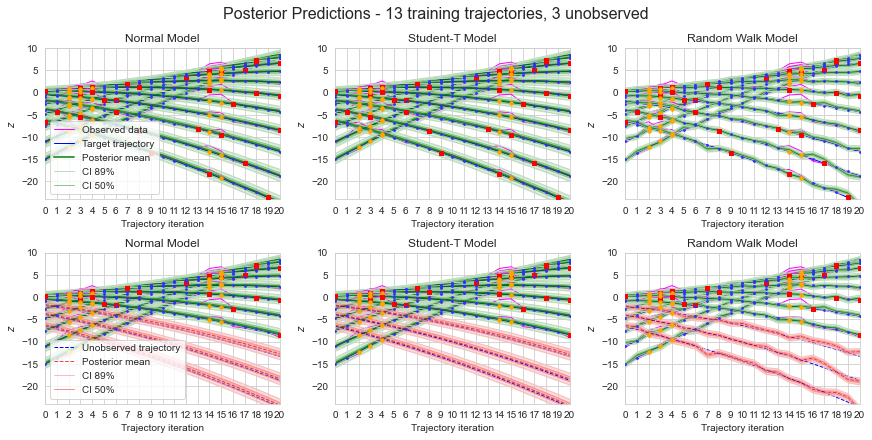

In [25]:
traj = z_target.shape[0]
unobs_t = traj - training_trajectories

fig = plt.figure(figsize=(fig_size_x, fig_size_y), constrained_layout=True)
gs = fig.add_gridspec(ncols=3, nrows=2)

plot_actuals(fig, gs[0, 0], obs_normal_lm, z_mask_missing, f'Normal Model')
plt.legend(loc=3)
plot_actuals(fig, gs[0, 1], obs_studentt_lm, z_mask_missing, f'Student-T Model')
plot_actuals(fig, gs[0, 2], obs_grw, z_mask_missing, f'Random Walk Model')

plot_actuals(fig, gs[1, 0], obs_normal_lm_missing, z_mask_trajectories, f'Normal Model')
plt.legend(loc=3)
plot_actuals(fig, gs[1, 1], obs_studentt_lm_missing, z_mask_trajectories, f'Student-T Model')
plot_actuals(fig, gs[1, 2], obs_grw_missing, z_mask_trajectories, f'Random Walk Model')

fig.suptitle(f'Posterior Predictions - {traj} training trajectories, {unobs_t} unobserved', fontsize=16)

Text(0.5, 0.98, 'Generated Trajectories - 13 training trajectories, 3 unobserved')

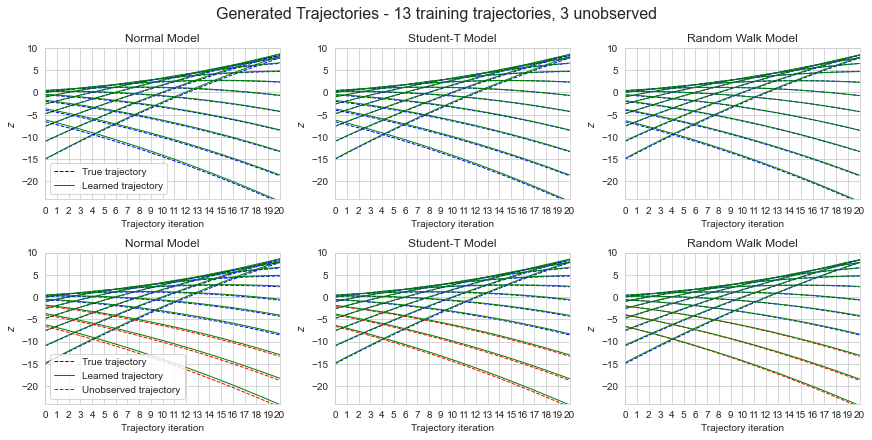

In [26]:
def plot_actuals_vs_true(fig, gs, z, mask, title):
    ax = fig.add_subplot(gs)
    t = np.arange(z.shape[1])
    ax.set_title(title)
    ax.set_xticks(t)
    ax.set_xlabel('Trajectory iteration')
    ax.set_ylabel('$z$')
    ax.set_xlim(0, len(t) - 1)
    ax.set_ylim(-z_abs_min, z_abs_max)

    l_1, l_2, l_3 = 'True trajectory', 'Unobserved trajectory', 'Learned trajectory'

    for ix in range(z.shape[0]):
        if np.all(mask[ix] == 1):
            plt.plot(t, z_target[ix], lw=1, ls='--', color=pal_3[5], label=l_2)
            l_2 = ''
        else:
            plt.plot(t, z_target[ix], lw=1, ls='--', color=pal_2[5], label=l_1)
            l_1 = ''
        plt.plot(t, z[ix], lw=1, color=pal_1[5], label=l_3)
        l_3 = ''
        
fig = plt.figure(figsize=(fig_size_x, fig_size_y), constrained_layout=True)
gs = fig.add_gridspec(ncols=3, nrows=2)

plot_actuals_vs_true(fig, gs[0, 0], z_model_lm_1, z_mask_missing, f'Normal Model')
plt.legend(loc=3)
plot_actuals_vs_true(fig, gs[0, 1], z_model_st_1, z_mask_missing, f'Student-T Model')
plot_actuals_vs_true(fig, gs[0, 2], z_model_grw_1, z_mask_missing, f'Random Walk Model')

plot_actuals_vs_true(fig, gs[1, 0], z_model_lm_2, z_mask_trajectories, f'Normal Model')
plt.legend(loc=3)
plot_actuals_vs_true(fig, gs[1, 1], z_model_st_2, z_mask_trajectories, f'Student-T Model')
plot_actuals_vs_true(fig, gs[1, 2], z_model_grw_2, z_mask_trajectories, f'Random Walk Model')

fig.suptitle(f'Generated Trajectories - {traj} training trajectories, {unobs_t} unobserved', fontsize=16)

## 10 Cumulative test results
Having developed the models as above, the chart below summarises the results of testing the model in various scenarios:

1. Run the three models **Normal**, **Student-T** and **Random Walk** with 13 trajectories, systematically increasing the number of unobserved trajectories from zero to five. This effectively tests the predictive power of the models in unobserved regions of the sample space, with the 'training' trajectories decreasing from thirteen, the first being a fit with no missing trajectories, the last being a fit with eight training trajectories.
2. We also run the same tests but decreasing the unobserved trajectories from the opposite end of the trajectory array, trajectory 13, removing in reverse order. This is to counter any artifacts in the shape of the trajectories or their relative positions.
3. For each of these runs, we test the effect of removing the outliers. 
4. We also test removing the sample observation noise level from the case with all the trajectories, testing both with and without outliers. We have plotted this at each end of the chart below, duplicating the figures for comparison purposes. The case of zero trajectories removed is also duplicated on the left and right of the chart for comparison purposes.
5. With fewer than eight trajectories observed out of thirteen, the model becomes poorly conditioned, we believe because then the observed data does not cover the point of inflection in the observations, which is effectively a saddle point in the model. In general, it is difficult to model a polynomial type inflection unless the observed data covers the transition through the change in gradient direction. In our case, the models then gave poor fits and singularities in the sampling.

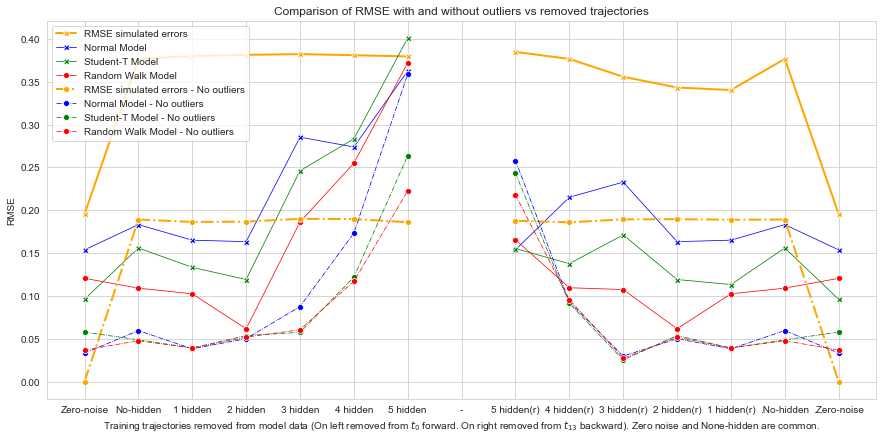

In [27]:
def get_previous_results():
    from io import StringIO
    experiment_results = StringIO('''
Model,Zero-noise,No-hidden,1 hidden,2 hidden,3 hidden,4 hidden,5 hidden,-,5 hidden(r),4 hidden(r),3 hidden(r),2 hidden(r),1 hidden(r),.No-hidden,.Zero-noise
Normal Model,0.1538,0.1833,0.1651,0.1634,0.2854,0.2739,0.3627,,0.154,0.2152,0.2329,0.1634,0.1651,0.1833,0.1538
Student-T Model,0.0961,0.156,0.1334,0.1192,0.2462,0.2834,0.4011,,0.1553,0.1377,0.1713,0.1192,0.1133,0.156,0.0961
Random Walk Model,0.1206,0.1091,0.1025,0.0617,0.1863,0.255,0.3722,,0.1656,0.1096,0.1075,0.0617,0.1025,0.1091,0.1206
Normal Model - No outliers,0.0332,0.0596,0.0383,0.0501,0.0876,0.1733,0.359,,0.2581,0.0931,0.0298,0.0501,0.0383,0.0596,0.0332
Student-T Model - No outliers,0.0578,0.0488,0.0392,0.0538,0.0575,0.122,0.2638,,0.2431,0.0915,0.0252,0.0538,0.0392,0.0488,0.0578
Random Walk Model - No outliers,0.0369,0.0477,0.0393,0.0519,0.0606,0.1172,0.2227,,0.218,0.0958,0.0272,0.0519,0.0393,0.0477,0.0369
RMSE simulated errors,0.1956,0.3767,0.38,0.3815,0.3823,0.3811,0.3796,,0.3849,0.3767,0.3559,0.3433,0.3404,0.3767,0.1956
RMSE simulated errors - No outliers,0,0.1892,0.1864,0.1868,0.19,0.1898,0.1861,,0.1878,0.186,0.1894,0.1896,0.189,0.1892,0
    ''')
    return pd.read_csv(experiment_results, sep=',', index_col=0)

def plot_previous_results(df):
    fig = plt.figure(figsize=(fig_size_x*2, fig_size_y), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlabel('Training trajectories removed from model data (On left removed from $t_0$ forward. On right removed from $t_{13}$ backward). Zero noise and None-hidden are common.')
    ax1.set_ylabel('RMSE')
    seaborn.lineplot(df.columns, df.values[6], label=df.index[6], color='orange', lw=2, marker='X')
    seaborn.lineplot(df.columns, df.values[0], label=df.index[0], color=pal_2[5], lw=.75, marker='X')
    seaborn.lineplot(df.columns, df.values[1], label=df.index[1], color=pal_1[5], lw=.75, marker='X')
    seaborn.lineplot(df.columns, df.values[2], label=df.index[2], color=pal_3[5], lw=.75, marker='o')
    seaborn.lineplot(df.columns, df.values[7], label=df.index[7], color='orange', lw=2, marker='o', ls='dashdot')
    seaborn.lineplot(df.columns, df.values[3], label=df.index[3], color=pal_2[5], lw=.75, marker='o', ls='dashdot')
    seaborn.lineplot(df.columns, df.values[4], label=df.index[4], color=pal_1[5], lw=.75, marker='o', ls='dashdot')
    seaborn.lineplot(df.columns, df.values[5], label=df.index[5], color=pal_3[5], lw=.75, marker='o', ls='dashdot')
    plt.title('Comparison of RMSE with and without outliers vs removed trajectories')
    plt.legend(loc=2)
    

experimental_results_data = get_previous_results()
plot_previous_results(experimental_results_data)

### 10.1 Discussion of results
From the chart above we make the following observations:

1. First of all it should be noted that for all three model the results fit the 'true' data closely. In all experiments the calculated models for cases with and without outliers have lower RMSE than that of the original sample data. This is encouraging as it suggests that model refinement has obtained a fit that is relatively impervious to sample noise, whether it is random Gaussian noise or systematic noise due to outliers.
2. As expected, the sample data without outliers allows a better fit to the 'true' data than the models generated from data with outliers. There is some indication that this difference becomes less as we enter the region where we have fewer training trajectories.
3. For both cases, with and without outliers, the Random Walk Model is better in terms of RMSE than the Student-T model, which is better than the Normal model. In the case where we remove outliers the difference is small and all three models perform well.


### 10.2 Conclusion
The intention of this project was to test the viability of using Bayesian learning with PyMC3 to determine the parameters of physical systems via their observed trajectories across a surface in a vector space.

1. We have been able to get good results for the inferred physical parameters across various scenarios and models.
2. We have shown that the Gaussian random walk model seems to have some benefits in being less susceptible to systematic outliers in the sample data than the Normal and Student-T models.
3. All three models were robust to various data sets, including sparse data, and converged quickly in real time.
4. There were limits to the extent to which unobserved trajectories could be inferred from the training trajectories within the context of the model run. We do not believe this is a limitation since in practice once the physical properties have been learned from the observed data, these parameters can be used to predict out of sample data without needing the context of the PyMC3 model, simply by plugging them into the target mathematical model.
6. The problem of regularizing the Gaussian random walk is a serious one and if this is to be used as a generative distribution in future we need to improve the automating of the regularization of the meta parameters.

We would like to continue this work and in particular extend it to the non-linear case, in the first instance to learn the properties of a simple harmonic oscillator from observed trajectories, rather than by solving the differential equations as can be done now.

References

1. T. Wiecki, [GLM: Robust Linear Regression](https://docs.pymc.io/notebooks/GLM-robust.html) (2018), PyMC3
2. J. Salvatier1, T. Wiecki, C. Fonnesbeck, [Probabilistic programming in Python using PyMC3](https://pdfs.semanticscholar.org/8085/b60ce1771647f11ccc4728397275b502f359.pdf) (2016), PeerJ Computer Science
3. J. Salvatier1, C. Fonnesbeck, T. Wiecki, [GLM: Robust Regression with Outlier Detection](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GLM-robust-with-outlier-detection.html) (2016), PyMC3
4. R. P. Feynman and A. R. Hibbs, Quantum Mechanics and Path Integrals McGraw–Hill Lectures/01.pdf (1965) 
5. C. Torre [Introduction. Configuration space. Equations of Motion. Velocity Phase Space](http://www.physics.usu.edu/torre/6010_Fall_2010/Lectures/01.pdf) (2010)
6. Léon Bottou, [Learning Representations Using Causal Invariance](https://www.april.sh/blog/2019/05/06/leon-bottou) (2019), ICLR 2019, New Orleans
7. Christian A. Tiemann, Joep Vanlier, Maaike H. Oosterveer, Albert K. Groen, Peter A. J. Hilbers, Natal A. W. van Riel [Parameter Trajectory Analysis to Identify Treatment Effects of Pharmacological Interventions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3731221) (2013) PLoS Comput Biol
8. A. Gelman, A. Jakulin, M. Grazia Pittau, Yu-Sung Su, [A default prior distribution for logistic and other regression models](http://www.stat.columbia.edu/~gelman/research/unpublished/priors3.pdf) (2006) columbia.edu
9. A. Vehtari: [Model assessment, selection and averaging](https://youtu.be/Re-2yVd0Mqk) (2018) Aalto University https://users.aalto.fi/~ave/index.html

$^*$We have sometimes used the term linear loosely to describe any function that is a linear superposition of parameters, the justification for this being that we can replace higher order terms with an additional variable, for example in $x^2$.